<a href="https://colab.research.google.com/github/swap-10/MusicGen/blob/main/NigelDataMusicGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Generation using LSTMs



---



# Getting and organizing the dataset

In [3]:
%%bash
mkdir abcdownloads
for i in {1..21}
do
foo=$(printf "http://www.nigelgatherer.com/tunes/abc/tb%02d.abc" $i)
name=$(printf "tb%02d.abc" $i)
wget -O ./abcdownloads/$name "${foo}"
done

--2021-10-04 10:01:36--  http://www.nigelgatherer.com/tunes/abc/tb01.abc
Resolving www.nigelgatherer.com (www.nigelgatherer.com)... 185.195.15.60
Connecting to www.nigelgatherer.com (www.nigelgatherer.com)|185.195.15.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15248 (15K) [text/plain]
Saving to: ‘./abcdownloads/tb01.abc’

     0K .......... ....                                       100% 65.1K=0.2s

2021-10-04 10:01:37 (65.1 KB/s) - ‘./abcdownloads/tb01.abc’ saved [15248/15248]

--2021-10-04 10:01:37--  http://www.nigelgatherer.com/tunes/abc/tb02.abc
Resolving www.nigelgatherer.com (www.nigelgatherer.com)... 185.195.15.60
Connecting to www.nigelgatherer.com (www.nigelgatherer.com)|185.195.15.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15999 (16K) [text/plain]
Saving to: ‘./abcdownloads/tb02.abc’

     0K .......... .....                                      100% 68.4K=0.2s

2021-10-04 10:01:38 (68.4 KB/s) - ‘./abcdownloads

<h2>Careful! This will delete the downloaded dataset. For experimentation, to re-download data
<h2>

In [ ]:
# Careful !


!rm -rf abcdownloads

Importing and installing requirements

In [ ]:
%tensorflow_version 2.x
# Sets the tensorflow version to 2.x (choosing from 1.x and 2.x)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

!pip install mitdeeplearning
import mitdeeplearning as mdl

import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity

     |████████████████████████████████| 2.1 MB 2.7 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=03f9c183db4fe16c5fd50eeaa0b2b68808bdbace30cf9780f8223750087e584b
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freepats libaudio2 timidity-daemon
Suggested packages:
  abcm2ps postscript-viewer nas fluid-soundfont-gm fluid-soundfont-gs pmidi
The following NEW packages will be installed:
  abcmidi freepats libaudio2 timidity timidity-daemon
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 29.9 MB of archives.
After this operation, 36.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 abcmidi amd64 20180222

GPU Not Necessary, but strongly recommended. On one instance, Training times observed were 8 minutes (GPU) v 7 hours (CPU)

In [ ]:
assert len(tf.config.list_physical_devices('GPU'))>0 
# Throws assertion error if no GPU

# Data Cleaning, Preparation and Checking

In [4]:
for i in range(1,2):
  with open('./abcdownloads/tb%02d.abc' %(i), "r+", encoding = "utf-8") as file:

      # Move the pointer (similar to a cursor in a text editor) to the end of the file
      file.seek(0, os.SEEK_END)

      # This code means the following code skips the very last character in the file -
      # i.e. in the case the last line is null we delete the last line
      # and the penultimate one
      pos = file.tell() - 2 
      if pos > 0:
          file.seek(pos, os.SEEK_SET)
          file.truncate()
for i in range(2,22):
  with open('./abcdownloads/tb%02d.abc' %(i), "r+", encoding = "utf-8") as file:

      # Move the pointer (similar to a cursor in a text editor) to the end of the file
      file.seek(0, os.SEEK_END)

      # This code means the following code skips the very last character in the file -
      # i.e. in the case the last line is null we delete the last line
      # and the penultimate one
      pos = file.tell() - 2 
      if pos > 0:
          file.seek(pos, os.SEEK_SET)
          file.truncate()
      file.seek(0, os.SEEK_END)
      file.write('\n')

In [12]:
a = ''
for i in range(1,22):
  print(i)
  with open('./abcdownloads/tb%02d.abc' %(i), encoding='latin-1') as f:
    a = a + f.read()
a = a.split('\n\n')
print("No. of songs:", len(a))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
No. of songs: 1036


In [13]:
a = '\n\n'.join(a)
mdl.lab1.extract_song_snippet(a)[:50]

Found 1041 songs in text


["X:001\nT:The Duke of Buccleugh's Tune\nB:Apollo's Banquet, 1990, via... \nB:The Popular Songs and Melodies of Scotland\nZ:Nigel Gatherer\nM:2/4\nL:1/8\nK:G\nG<EG<E|A>GAB|G<EG>A|B2 d z|\nGE/F/ GE|A>GAB|G<EG>A|B2 d z|]",
 "X:002\nT:I Fee'd a Lad at Michaelmas\nT:O Can You Labour Lea\nB:Johnson's Scots Musical Museum, via...\nB:The Popular Songs and Melodies of Scotland\nZ:Nigel Gatherer\nM:2/4\nL:1/8\nK:G\nG>GGB|A>GAB|G<GGB|e3 g|\nG>GGB|A>GAB|G<EE>D|G3|]",
 "X:003\nT:The Miller's Wedding\nT:The Miller's Daughter\nB:Cumming's Collection, 1780, via...\nB:The Popular Songs and Melodies of Scotland\nZ:Nigel Gatherer\nM:2/4\nL:1/8\nK:G\nD|G<GG>E|A>GAB|D<DE>D|G3 B|\nG<GG>E|A>GAB|D<DE>D|G3 z|]",
 "X:004\nT:John O'Groats Jig\nB:Kohlers Violin repository - slightly adapted\nC:John Bain, Wick\nZ:Nigel Gatherer\nM:6/8\nL:1/8\nO:Scottish\nR:jig\nK:Dm\nA/G/|FGA DFA|dfd ecA|Agf edc|=Bed c=BA|\nFGA DFA|dfd ecA|Bgf ed^c|dDD D2:|\nA|dfa afd|gbg ecA|dfa afd|=Bed c=BA|\ndfa afd|gbg ecA|Bgf ed^c|dDD D2:|"

In [ ]:
a = a.split('\n\n')
songs  = a
print(len(songs))
example_song = songs[3]
print("\nExample song: \n", example_song, sep='')

1036

Example song: 
X:004
T:John O'Groats Jig
B:Kohlers Violin repository - slightly adapted
C:John Bain, Wick
Z:Nigel Gatherer
M:6/8
L:1/8
O:Scottish
R:jig
K:Dm
A/G/|FGA DFA|dfd ecA|Agf edc|=Bed c=BA|
FGA DFA|dfd ecA|Bgf ed^c|dDD D2:|
A|dfa afd|gbg ecA|dfa afd|=Bed c=BA|
dfa afd|gbg ecA|Bgf ed^c|dDD D2:|


In [ ]:
mdl.lab1.play_song(a[5])

In [ ]:
# Join list of songs into a single string containing all songs
songs_all = "\n\n".join(songs)

# Unique characters
print("Total characters:", len(songs_all))
vocab = sorted(set(songs_all))
print("There are", len(vocab), "unique characters in the dataset")

Total characters: 346405
There are 106 unique characters in the dataset


<h1>Vectorizing<h1>

In [ ]:
# A mapping for characters to numbers and one for numbers to characters
chartoidx = {c:i for i, c in enumerate(vocab)}
def chartoidxfnc(string):
  return chartoidx[string]

idxtochar = np.array(vocab)

for char, idx in zip(chartoidx, range(20)):
  print(repr(char), chartoidxfnc(char))

'\x01' 0
'\n' 1
' ' 2
'!' 3
'"' 4
'#' 5
'%' 6
'&' 7
"'" 8
'(' 9
')' 10
'+' 11
',' 12
'-' 13
'.' 14
'/' 15
'0' 16
'1' 17
'2' 18
'3' 19


In [ ]:
def vectorize_string(string):
  v_string = map(chartoidxfnc, list(string))
  v_string = list(v_string)
  return np.array(v_string)

print(len(list(songs_all)))  # Gives total num of chars in dataset
vectorized_songs = vectorize_string(songs_all)

# Some quick checking

print(repr(songs_all[:10]))
print(idxtochar[vectorized_songs[:10]])
print(vectorized_songs[:10])
vectorized_songs.shape[0]

346405
'X:001\nT:Th'
['X' ':' '0' '0' '1' '\n' 'T' ':' 'T' 'h']
[56 26 16 16 17  1 52 26 52 71]


346405

# Creating Training Data

In [ ]:
# Creating training examples

def get_batch(vectorized_songs, seq_length, batch_size):

  n = vectorized_songs.shape[0]

  # Randomly choosing starting indices for the examples
  idx = np.random.choice(n - seq_length, batch_size)
  # Chooses (batch_size) number of integers in range(n-seq_length)
  # As last sequence starting point must be maximum n-seq_length to avoid
  # out of range

  # Getting the input sequences
  input_batch = [vectorized_songs[start : start+seq_length] for start in idx]
  # Output sequences (shifting forward input sequences by 1)
  output_batch = [vectorized_songs[start+1 : start+seq_length+1] for start in idx]

  # Inputs and true targets (to train on and measure performance against)
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  # batch_size number of sequences of length seq_length
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)
# Gives 1 batch of sequence length 5

for i, (input_idx, target_idx) in enumerate(
    zip(np.squeeze(x_batch), np.squeeze(y_batch))):
  print("Timestep", i)
  print("Input: {} ({})".format(input_idx, repr(idxtochar[input_idx])))
  print("Expected output: {} ({})".format(target_idx, repr(idxtochar[target_idx])))

Timestep 0
Input: 15 ('/')
Expected output: 33 ('A')
Timestep 1
Input: 33 ('A')
Expected output: 15 ('/')
Timestep 2
Input: 15 ('/')
Expected output: 91 ('|')
Timestep 3
Input: 91 ('|')
Expected output: 67 ('d')
Timestep 4
Input: 67 ('d')
Expected output: 30 ('>')


# Defining the model

In [ ]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
      rnn_units,
      return_sequences=True,
      recurrent_initializer='glorot_uniform',
      recurrent_activation='sigmoid',
      stateful=True
  )

def def_model(vocab_size, embedding_dims, rnn_units, batch_size):
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size,
                                                         embedding_dims,
                                                         batch_input_shape=[batch_size, None]
                                                         ),
                               
                               LSTM(rnn_units),

                               # A fully connected layer

                               tf.keras.layers.Dense(vocab_size)
  ])

  return model



In [ ]:
model = def_model(len(vocab), embedding_dims=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           27136     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 106)           108650    
Total params: 5,382,762
Trainable params: 5,382,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Checking out the form of input and output

x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
# Returns 32 sequences of sequence length 100 characters to x
pred = model(x)
print("Input shape: ", x.shape,
      "\nPrediction/Output shape: ", pred.shape, " # (Batch size, seq_length, vocab size)")

Input shape:  (32, 100) 
Prediction/Output shape:  (32, 100, 106)  # (Batch size, seq_length, vocab size)


<h1>Predictions from untrained model</h1>

In [ ]:
sample_indices = tf.random.categorical(pred[0], num_samples=1)
sample_indices = tf.squeeze(sample_indices, axis=-1).numpy()
print(sample_indices)
print(repr(''.join(idxtochar[x[0]])))  # Inputs
print(repr(''.join(idxtochar[sample_indices])))

[ 64   4  51 103  45  71  44  37  47  37  30  68   7  92   1  40  73  56
  99  87   4  91  84  26  19   0   1  78  44  68  85  35  71   5  50  36
 101  70  86   9  59  91  96  35  41  80  37  38  75  15  45  98  45  50
   6   5  17  15  72  43  86  38  83  92 104  85  54   9  46  77  98 104
  14  71  26  38  36  19  58  30  42  84  36  51  57   3  63  61  68  63
   7  68  50  41  81  67  87  39  36  41]
'cB |\n      AcBA F2 AF | EFAB cABc | d3 f ecAc |   BAGB     A3    ||\n\nX:690\nT:Return from Fingal\nS:Cr'
'a"SíMhLEOE>e&}\nHjXÙx"|u:3\x01\noLevCh#RDågw([|ÒCIqEFl/MÕMR%#1/iKwFt}òvV(NnÕò.h:FD3Z>JuDSY!_]e_&eRIrdxGDI'


# Training the model

In [ ]:
def loss_fn(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(
      labels,
      logits,
      from_logits=True
  )

  return loss

In [ ]:
example_batch_loss = loss_fn(y, pred)

print("Scalar loss: ", example_batch_loss.numpy().mean())

Scalar loss:  4.6639113


In [ ]:
# Hyperparameters

num_iterations = 6000
batch_size = 4
seq_length = 99
learning_rate = 3e-3

vocab_size = len(vocab)
embedding_dims = 256
rnn_units = 1024

checkpoint_dir = '/content/drive/MyDrive/MIT_6S191/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'nigeldatamusic_ckpt')

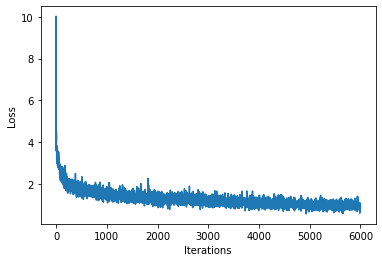

100%|██████████| 6000/6000 [09:37<00:00, 10.40it/s]

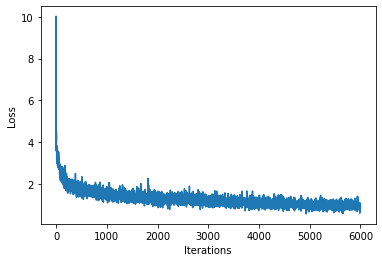

In [ ]:

model = def_model(vocab_size, embedding_dims, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function  # Converts function to callable tensorflow graph
def train_step(x, y):
  # Using tf.GradientTape() to later perform backpropagation easily
  with tf.GradientTape() as tape:
    y_sharp = model(x)  # Predictions
    loss = loss_fn(y, y_sharp)  # Loss btw true and predicted values
  
  gradients = tape.gradient(loss, model.trainable_variables)
  # This is to ensure that the backpropagation performed gets gradients
  # w.r.t all model parameters

  # Applying the gradients to update the parameters of the model
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

# Training the model

history = []  # To plot the graph
plotter = mdl.util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'):
  tqdm._instances.clear()

# tqdm is used to give a useful progress bar and status of the operation

for iter in tqdm(range(num_iterations)):

  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  history.append(loss.numpy().mean())
  plotter.plot(history)

  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)
  # Checkpoint updated every hundred iterations
  # The weights of the model itself are updated every time loss_fn is called

model.save_weights(checkpoint_prefix)  # Saving final trained weights
model.save(os.path.join(checkpoint_dir, 'MusicNigelModel1.h5'))

In [ ]:
print(loss)

tf.Tensor(
[[2.67594171e+00 8.31339300e-01 1.32218793e-01 5.36433840e+00
  1.28119624e+00 6.82382536e+00 1.18203783e+00 3.16822469e-01
  3.95717770e-01 1.64924967e+00 1.25273347e+00 3.03859043e+00
  1.32520567e-03 3.30942929e-01 1.40322018e+00 1.67930210e+00
  5.51784784e-03 3.42773408e-01 4.87155795e-01 5.51887155e-01
  1.48300982e+00 1.35347378e+00 6.11766614e-03 2.32922125e+00
  4.23173571e+00 7.30648488e-02 2.00672876e-02 4.78865981e-01
  1.07456875e+00 3.17117524e+00 3.26152086e+00 7.93713570e-01
  2.24737674e-02 2.05464005e+00 1.01548553e+00 1.62637848e-02
  7.49040067e-01 3.46322991e-02 1.53728271e+00 7.14802921e-01
  8.84239137e-01 3.73784616e-03 2.68200874e+00 8.62868667e-01
  1.49970114e+00 2.44128495e-03 1.02043502e-01 2.84303948e-02
  1.10925436e+00 8.59799147e-01 8.03826690e-01 9.96569754e-04
  6.78008437e-01 7.81692505e-01 1.10433459e+00 9.36082844e-03
  2.67584413e-01 2.14172363e-01 1.83035210e-01 2.09929198e-01
  5.77886403e-02 2.44902357e-01 6.20409608e-01 2.02648103e-

<h1>Using the model to generate music</h1>

In [ ]:
%%bash
mkdir songs
mkdir fullsongs
apt update
apt install ffmpeg

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

mkdir: cannot create directory ‘fullsongs’: File exists






In [ ]:
model = def_model(vocab_size, embedding_dims, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


'''
model = tf.keras.models.load_model(os.path.join(checkpoint_dir, 'MusicNigelModel1.h5'))
model = def_model(vocab_size, embedding_dims, rnn_units, batch_size=1)
model.build(tf.TensorShape([1, None]))
'''

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            27136     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 106)            108650    
Total params: 5,382,762
Trainable params: 5,382,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:

def gen_song(model, start_string, gen_length=1000):

  input_eval = [chartoidx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  song_gen = []

  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(gen_length)):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
    
    input_eval = tf.expand_dims([predicted_id], 0)
    song_gen.append(idxtochar[predicted_id])

  return (start_string+''.join(song_gen))

In [ ]:
tot = 0

In [ ]:
# Assign to rangeval the number of times you wan to loop this
rangeval = 10
for iters in range(rangeval):
  song_generated = gen_song(model, start_string="X", gen_length=2000)
  song_generated = gen_song(model, start_string="X", gen_length=2000)
  all_songs_play = mdl.lab1.extract_song_snippet(song_generated)

  for i, song in enumerate(all_songs_play):
    waveform = mdl.lab1.play_song(song)

    if waveform:
      with open('./songs/gensong%02d.wav' %(tot), 'wb') as f:
        f.write(waveform.data)
      with open('./songs/songnames.txt', 'a') as f:
        f.write("file 'gensong%02d.wav'\n" %(tot))
      print("Generated song", tot)
      tot += 1
      # ipythondisplay.display(waveform)

100%|██████████| 2000/2000 [00:16<00:00, 120.09it/s]


Found 4 songs in text
Generated song 0
Generated song 1


100%|██████████| 2000/2000 [00:16<00:00, 120.87it/s]


Found 6 songs in text
Generated song 2
Generated song 3
Generated song 4
Generated song 5


100%|██████████| 2000/2000 [00:16<00:00, 121.78it/s]


Found 6 songs in text
Generated song 6
Generated song 7
Generated song 8


100%|██████████| 2000/2000 [00:16<00:00, 119.22it/s]


Found 5 songs in text
Generated song 9
Generated song 10
Generated song 11
Generated song 12
Generated song 13


100%|██████████| 2000/2000 [00:16<00:00, 122.31it/s]


Found 2 songs in text
Generated song 14
Generated song 15


100%|██████████| 2000/2000 [00:16<00:00, 121.13it/s]


Found 7 songs in text
Generated song 16
Generated song 17
Generated song 18
Generated song 19
Generated song 20


100%|██████████| 2000/2000 [00:16<00:00, 120.06it/s]


Found 7 songs in text
Generated song 21
Generated song 22
Generated song 23
Generated song 24


100%|██████████| 2000/2000 [00:16<00:00, 121.03it/s]


Found 5 songs in text
Generated song 25
Generated song 26
Generated song 27
Generated song 28


100%|██████████| 2000/2000 [00:16<00:00, 120.44it/s]


Found 5 songs in text
Generated song 29
Generated song 30
Generated song 31
Generated song 32


100%|██████████| 2000/2000 [00:16<00:00, 120.93it/s]


Found 6 songs in text
Generated song 33
Generated song 34
Generated song 35
Generated song 36
Generated song 37
Generated song 38


In [ ]:
!ffmpeg -f concat -i ./songs/songnames.txt -c copy ./fullsongs/fullsong.wav

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
%%bash
rm -rf songs 
ffmpeg -i ./fullsongs/fullsong.wav -vn -ar 44100 -ac 2 -b:a 192k ./fullsongs/fullsong.mp3

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
%%bash
ls -alh ./fullsongs/

total 577M
drwxr-xr-x 3 root root 4.0K Sep 30 15:40 .
drwxr-xr-x 1 root root 4.0K Sep 30 15:40 ..
-rw-r--r-- 1 root root  70M Sep 30 15:41 fullsong.mp3
-rw-r--r-- 1 root root 508M Sep 30 15:39 fullsong.wav
drwxr-xr-x 2 root root 4.0K Sep 30 15:39 .ipynb_checkpoints


In [ ]:
# To delete the much larger .wav file
!rm ./fullsongs/fullsong.wav